## 1. Article level

In [1]:
#import
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as s
import dataframe_image as dfi
import networkx as nx
import mantel

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### covid-science.txt

In [2]:
def load_data(path,file_name,seperator):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    document = ''
    i=0
    with open( os.path.join(path, file_name) ,"r", encoding="utf8") as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for line in fin.readlines():
            text = line.strip()
            i=i+1
            if text !='':
                document = document+text
                if text == seperator:
                    documents_list.append(document)
                    document = ''
        documents_list.append(document)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [3]:
document_list,titles,word_count_science=load_data("","covid-science-30.txt",'NEW_PAPER')

Number of words in text file : 205313
Total Number of Documents: 30


In [4]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        tokens = [i for i in tokens if len(i)>4]
        print(tokens)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [5]:
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnetmethodology', 'predicting', 'covid', '19based', 'chest', 'imagess', 'tabik', 'gómez', 'martín', 'rodríguez', 'sevillano', 'garcía', 'charte', 'guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova', 'olmedo', 'sánchez', 'herreraabstract', 'currently', 'coronavirus', 'disease', 'covid', 'infectious', 'diseases', 'century', 'diagnosed', 'using', 'testing', 'scans', 'orchest', 'images', 'computed', 'tomography', 'scanners', 'testing', 'available', 'mostmedical', 'centers', 'hence', 'cases', 'imagesbecome', 'effective', 'assisting', 'clinicians', 'making', 'decisions', 'learning', 'neural', 'networkshave', 'great', 'potential', 'building', 'covid', 'triage', 'systemsand', 'detecting', 'covid', 'patients', 'especially', 'patients', 'withlow', 'severity', 'unfortunately', 'current', 'databases', 'allowbuilding', 'systems', 'highly', 'heterogeneousand', 'biased', 'towards', 'severe', 'cases', 'article', 'threefold', 'demystify', 'sensit

In [6]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [7]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    #print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [8]:
# LSA Model
number_of_topics=25
words=word_count_science
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_science =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [9]:
#These variables are for further experimentation in vertical comparission mantel test
model_science_articles = create_gensim_lsa_model(clean_text,number_of_topics,words)

In [10]:
dict(model_science.show_topic(0, topn=5))

{'covid': 0.5709789928348202,
 'imag': 0.3019026799708713,
 'model': 0.2285584109775616,
 'dataset': 0.1514562542660673,
 'infect': 0.13063753072698492}

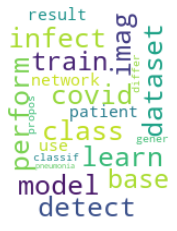

In [11]:
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph21.png')

In [12]:
# LSA Model

a=pd.DataFrame()

for i in range(number_of_topics):
    words_science =dict(model_science.show_topic(i, topn=words))
    b=pd.DataFrame(words_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled24.png')

cosine-similarity
             covid       imag      model    dataset     infect
covid            1  0.0860701  0.0425372 -0.0812714  0.0806363
imag     0.0860701          1 -0.0998757   0.183615 -0.0449446
model    0.0425372 -0.0998757          1  0.0123155   0.047749
dataset -0.0812714   0.183615  0.0123155          1  -0.168176
infect   0.0806363 -0.0449446   0.047749  -0.168176          1


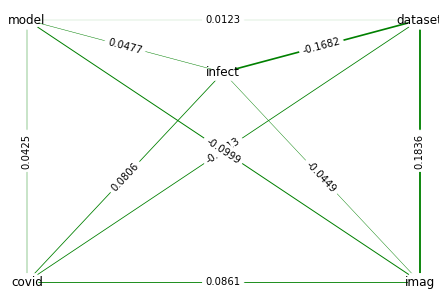

In [13]:
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='green',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig24.png')

### covid-psychology-large.txt

In [14]:
document_list,titles,word_count_psy=load_data("","covid-psychology-30.txt",'NEW PAPER')

Number of words in text file : 143564
Total Number of Documents: 30


In [15]:
clean_text=preprocess_data(document_list)

['international', 'sociology2021', 'author', '2020article', 'reuse', 'guidelines', 'sagepub', 'journals', 'permissionsdoi', '0268580920948807journals', 'sagepub', 'isspsychology', 'politics', 'ofcovid', 'misinfodemics', 'peoplebelieve', 'misinfodemics', 'sonia', 'mukhtaruniversity', 'management', 'technology', 'lahore', 'pakistanabstractmisinfodemics', 'related', 'covid', 'negatively', 'impacted', 'people', 'lives', 'adversehealth', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicateevidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'emerged', 'effects', 'ofmisinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevierabout', 'covid', 'related', 'misinfodemics', 'considered', 'reviewed', 'article', 'thisreview', 'examines', 'mechanisms', 'operational', 'structure', 'prevalence', 'pr

In [16]:
# LSA Model
number_of_topics=30
words=word_count_psy
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))#dict and encoding matrix values


In [17]:
#These variables are for further experimentation in vertical comparission mantel test
model_psy_articles=create_gensim_lsa_model(clean_text,number_of_topics,words)

In [18]:
dict(model_psy.show_topic(0,topn=5))

{'psycholog': 0.3166750431095782,
 'covid': 0.29324164057198565,
 'student': 0.2900412043705133,
 'train': 0.26795580949551717,
 'pandem': 0.2188306861058129}

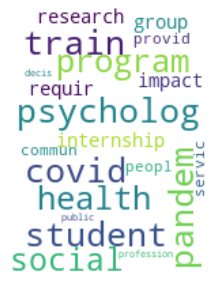

In [19]:
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph22.png')

In [20]:
# LSA Model

a=pd.DataFrame()

for i in range(number_of_topics):
    words_psy =dict(model_psy.show_topic(i, topn=words))
    b=pd.DataFrame(words_psy,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled25.png')

cosine-similarity
           psycholog      covid    student      train     pandem
psycholog          1   0.166527  0.0572926  0.0530091   0.016191
covid       0.166527          1  0.0107449 -0.0122306   0.279669
student    0.0572926  0.0107449          1   0.144694  0.0215532
train      0.0530091 -0.0122306   0.144694          1   0.255639
pandem      0.016191   0.279669  0.0215532   0.255639          1


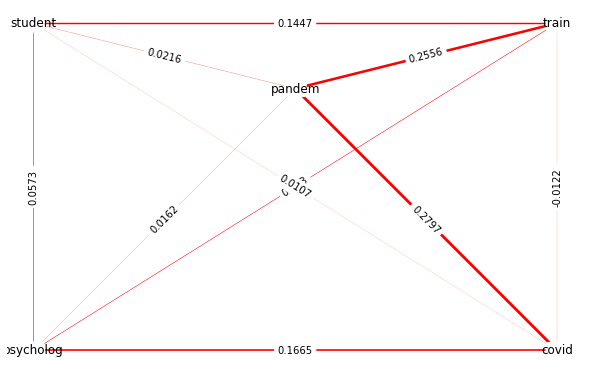

In [21]:
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='r',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig25.png')

In [22]:
def mantel_test(n):
    words_science = dict(model_science.show_topic(0, topn=word_count_science))
    words_psy = dict(model_psy.show_topic(0, topn=word_count_psy))

    top_words_science = dict(model_science.show_topic(0, topn=n)) 
    top_words_psy = dict(model_psy.show_topic(0,topn=n)) 


    c={} #law words in non law
    for key in top_words_science:
        try:
            c[key] = words_psy[key]
        except KeyError:
            c[key] = 0

    top_words_psy.update(c)

    b={} #non law words in law
    for key in top_words_psy:
        try:
            b[key] = words_science[key]
        except KeyError:
            b[key] = 0

    b.update(top_words_science)
    top_words_science=b

    #pairwise distance for law
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_science =dict(model_science.show_topic(i, topn=word_count_science))
        b=pd.DataFrame(words_from_science,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_science.keys()), 
                      index = list(top_words_science.keys()))

    l = list(top_words_science.keys())

    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df1 = df.to_numpy()
    #pairwise distace for non-law
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_psy =dict(model_psy.show_topic(i, topn=word_count_psy))
        b=pd.DataFrame(words_from_psy,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_psy.keys()), 
                      index = list(top_words_psy.keys()))

    l = list(top_words_psy.keys())
    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df2 = df.to_numpy()
    

    dist1 = list(df1[np.triu_indices(len(top_words_science), k = 1)])

    

    dist2 = list(df2[np.triu_indices(len(top_words_psy), k = 1)])

    return mantel.test(dist1, dist2, perms=10000, method='pearson', tail='upper')

In [23]:
mantel_test(5)

Pairwise-distance
             psycholog        covid   student     train    pandem      imag  \
psycholog  9.01749e-11     0.816579  0.622792   0.38925  0.306859  0.897931   
covid         0.816579  2.30848e-08   1.04356  0.822351  0.804158   1.16049   
student       0.622792      1.04356         0  0.777984  0.734672   1.08699   
train          0.38925     0.822351  0.777984         0  0.484324  0.807562   
pandem        0.306859     0.804158  0.734672  0.484324         0  0.973345   
imag          0.897931      1.16049   1.08699  0.807562  0.973345         0   
model         0.785539      1.10842   1.03352  0.807451  0.829399   1.25052   
dataset       0.699286       1.1172  0.950961  0.834674   0.78568   1.03181   
infect        0.723903      1.04633  0.989905     0.743  0.748457   1.17826   

                 model      dataset    infect  
psycholog     0.785539     0.699286  0.723903  
covid          1.10842       1.1172   1.04633  
student        1.03352     0.950961  0.989905  

(-0.44085914260131626, 0.9074, -1.3372906426116458)

In [24]:
mantel_test(10)

Pairwise-distance
              psycholog        covid   student     train    pandem    program  \
psycholog   9.01749e-11     0.816579  0.622792   0.38925  0.306859  0.0659961   
covid          0.816579  2.30848e-08   1.04356  0.822351  0.804158   0.823755   
student        0.622792      1.04356         0  0.777984  0.734672   0.628998   
train           0.38925     0.822351  0.777984         0  0.484324   0.392055   
pandem         0.306859     0.804158  0.734672  0.484324         0   0.307627   
program       0.0659961     0.823755  0.628998  0.392055  0.307627          0   
health         0.222706     0.793277  0.628922  0.459826   0.29227   0.223288   
social         0.484506     0.952515  0.793976  0.620905  0.541152   0.480121   
internship            0            0         0         0         0          0   
group          0.132837      0.81529  0.635026  0.416287  0.331218   0.138806   
imag           0.897931      1.16049   1.08699  0.807562  0.973345    0.90484   
model     

(-0.1305205827425967, 0.7165, -0.58437819549746)

## 2. 2-3 paragraphs

### covid-science.txt

In [25]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    document = ''
    i=0
    with open( os.path.join(path, file_name) ,"r",encoding="utf8") as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for word in words:
                i=i+1
                document = document+word+' '
                if i == 200:
                    documents_list.append(document)
                    document,i = '',0
                    if len(documents_list) == 2:
                        break
    print("Total Number of Documents:",len(documents_list))
    #titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [26]:
document_list,titles,word_count_science=load_data("","covid-science-30.txt")

Number of words in text file : 205313
Total Number of Documents: 2


In [27]:
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnet', 'methodology', 'predicting', 'covid', 'based', 'chest', 'images', 'tabik', 'gómez', 'martín', 'rodríguez', 'sevillano', 'garcía', 'charte', 'guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova', 'olmedo', 'sánchez', 'herrera', 'abstract', 'currently', 'coronavirus', 'disease', 'covid', 'infectious', 'diseases', 'century', 'diagnosed', 'using', 'testing', 'scans', 'chest', 'images', 'computed', 'tomography', 'scanners', 'testing', 'available', 'medical', 'centers', 'hence', 'cases', 'images', 'become', 'effective', 'assisting', 'clinicians', 'making', 'decisions', 'learning', 'neural', 'networks', 'great', 'potential', 'building', 'covid', 'triage', 'systems', 'detecting', 'covid', 'patients', 'especially', 'patients', 'severity', 'unfortunately', 'current', 'databases', 'allow', 'building', 'systems', 'highly', 'heterogeneous', 'biased', 'towards', 'severe', 'cases', 'article', 'threefold', 'demystify', 'sensitivities', 'ach

In [28]:
# LSA Model
number_of_topics=2
words_nscience=len(clean_text[0])+len(clean_text[1])
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words_nscience)
words_science =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [29]:
#These variables are for further experimentation in vertical comparission mantel test
model_science_p=create_gensim_lsa_model(clean_text,number_of_topics,words_nscience)

In [30]:
words_nscience

238

In [31]:
dict(model_science.show_topic(0, topn=5))

{'support': 0.3289947178827896,
 'granada': 0.24814037209037243,
 'covid': 0.22769581399154293,
 'programm': 0.21932981192185974,
 'research': 0.21932981192185974}

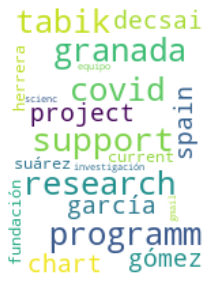

In [32]:
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph23.png')

In [33]:
# LSA Model

a=pd.DataFrame()

for i in range(number_of_topics):
    words_science =dict(model_science.show_topic(i, topn = words_nscience))
    b=pd.DataFrame(words_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled26.png')

cosine-similarity
            support   granada      covid   programm   research
support           1  0.956969 -0.0794645          1          1
granada    0.956969         1   0.213226   0.956969   0.956969
covid    -0.0794645  0.213226          1 -0.0794645 -0.0794645
programm          1  0.956969 -0.0794645          1          1
research          1  0.956969 -0.0794645          1          1


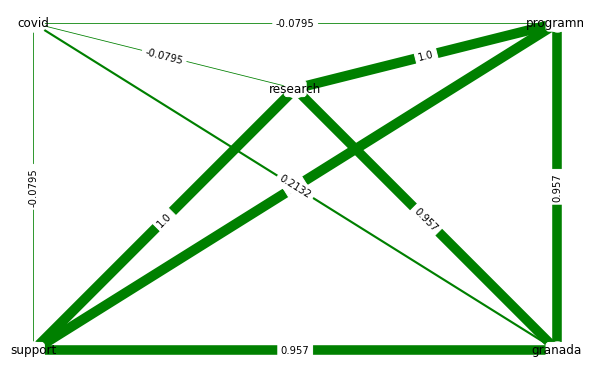

In [34]:
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='green',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig26.png')

### covid-psycology.txt

In [35]:
document_list,titles,word_count_psy=load_data("","covid-psychology-30.txt")

Number of words in text file : 143564
Total Number of Documents: 2


In [36]:
clean_text=preprocess_data(document_list)

['international', 'sociology', 'author', 'article', 'reuse', 'guidelines', 'sagepub', 'journals', 'permissions', '0268580920948807', 'journals', 'sagepub', 'psychology', 'politics', 'covid', 'misinfodemics', 'people', 'believe', 'misinfodemics', 'sonia', 'mukhtar', 'university', 'management', 'technology', 'lahore', 'pakistan', 'abstract', 'misinfodemics', 'related', 'covid', 'negatively', 'impacted', 'people', 'lives', 'adverse', 'health', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicate', 'evidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'emerged', 'effects', 'misinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevier', 'about', 'covid', 'related', 'misinfodemics', 'considered', 'reviewed', 'article', 'review', 'examines', 'mechanisms', 'operational', 'structure', 'preval

In [37]:
# LSA Model
number_of_topics=2
words_npsy=len(clean_text[0])+len(clean_text[1])
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words_npsy)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))##dict and encoding matrix values

In [38]:
#These variables are for further experimentation in vertical comparission mantel test
model_psy_p = create_gensim_lsa_model(clean_text,number_of_topics,words_npsy)

In [39]:
dict(model_psy.show_topic(0, topn=5))

{'misinfodem': 0.5033743541941375,
 'covid': 0.36297115033235167,
 'articl': 0.21459251935197474,
 'commun': 0.14837863098037699,
 'mechan': 0.14837863098037687}

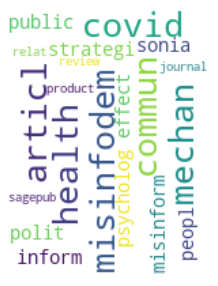

In [40]:
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph24.png')

In [41]:
# LSA Model

a=pd.DataFrame()

for i in range(number_of_topics):
    words_psy =dict(model_psy.show_topic(i, topn=words_npsy))
    b=pd.DataFrame(words_psy,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled27.png')

cosine-similarity
           misinfodem     covid    articl    commun    mechan
misinfodem          1  0.976353  0.993795  0.755596  0.755596
covid        0.976353         1  0.946251  0.879335  0.879335
articl       0.993795  0.946251         1  0.678051  0.678051
commun       0.755596  0.879335  0.678051         1         1
mechan       0.755596  0.879335  0.678051         1         1


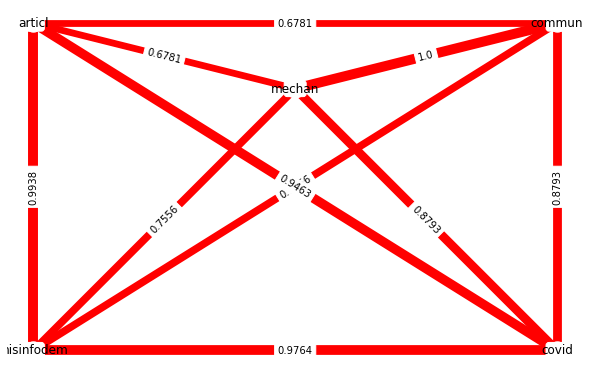

In [42]:
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='r',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig27.png')

In [43]:
mantel_test(5)

Pairwise-distance
           misinfodem        covid       articl commun mechan      support  \
misinfodem          0            0            0      0      0            0   
covid               0  7.45058e-09     0.378443      0      0     0.628979   
articl              0     0.378443  1.31709e-09      0      0     0.423546   
commun              0            0            0      0      0            0   
mechan              0            0            0      0      0            0   
support             0     0.628979     0.423546      0      0  7.45058e-09   
granada             0      0.47364     0.266413      0      0     0.168269   
programm            0     0.545218     0.293443      0      0     0.133207   
research            0     0.545218     0.293443      0      0     0.133207   

              granada   programm   research  
misinfodem          0          0          0  
covid         0.47364   0.545218   0.545218  
articl       0.266413   0.293443   0.293443  
commun           

(-0.12443276806076488, 0.6558, -0.5181483726137808)

In [44]:
mantel_test(10)

Pairwise-distance
           misinfodem        covid       articl commun mechan health strategi  \
misinfodem          0            0            0      0      0      0        0   
covid               0  7.45058e-09     0.378443      0      0      0        0   
articl              0     0.378443  1.31709e-09      0      0      0        0   
commun              0            0            0      0      0      0        0   
mechan              0            0            0      0      0      0        0   
health              0            0            0      0      0      0        0   
strategi            0            0            0      0      0      0        0   
psycholog           0            0            0      0      0      0        0   
misinform           0            0            0      0      0      0        0   
inform              0            0            0      0      0      0        0   
support             0     0.628979     0.423546      0      0      0        0   
granada   

(-0.16750679673139607, 0.8834, -1.1533417111590423)

## Paragraph level

### covid-science.txt

In [45]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r",encoding='UTF8') as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for line in fin.readlines():
            text = line.strip()
            if text !='':
                documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [46]:
document_list,titles,word_count_science=load_data("","covid-science-30.txt")

Number of words in text file : 205313
Total Number of Documents: 23788


In [47]:
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnet']
['methodology', 'predicting', 'covid']
['based', 'chest', 'images']
['tabik', 'gómez', 'martín', 'rodríguez', 'sevillano', 'garcía', 'charte']
['guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova']
['olmedo', 'sánchez', 'herrera']
['abstract', 'currently', 'coronavirus', 'disease', 'covid']
['infectious', 'diseases', 'century', 'diagnosed', 'using', 'testing', 'scans']
['chest', 'images', 'computed', 'tomography']
['scanners', 'testing', 'available']
['medical', 'centers', 'hence', 'cases', 'images']
['become', 'effective', 'assisting', 'clinicians', 'making', 'decisions', 'learning', 'neural', 'networks']
['great', 'potential', 'building', 'covid', 'triage', 'systems']
['detecting', 'covid', 'patients', 'especially', 'patients']
['severity', 'unfortunately', 'current', 'databases', 'allow']
['building', 'systems', 'highly', 'heterogeneous']
['biased', 'towards', 'severe', 'cases', 'article', 'threefold', 'demystify', 'sens

In [48]:
# LSA Model
number_of_topics=100
words=word_count_science
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_law =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [49]:
#These variables are for further experimentation in vertical comparission mantel test
model_science_paragraph=create_gensim_lsa_model(clean_text,number_of_topics,words)

In [50]:
dict(model_science.show_topic(0, topn=5))

{'covid': 0.8660700355392115,
 'imag': 0.28583433568785827,
 'detect': 0.16478264861820718,
 'model': 0.10872916366533712,
 'dataset': 0.10315349187066715}

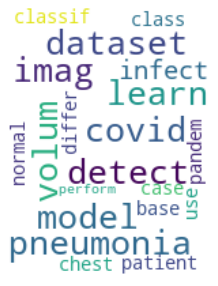

In [51]:
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph25.png')

In [52]:
# LSA Model

a=pd.DataFrame()

for i in range(number_of_topics):
    words_science =dict(model_science.show_topic(i, topn=words))
    b=pd.DataFrame(words_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled28.png')

cosine-similarity
               covid         imag       detect        model      dataset
covid              1   0.00093759   0.00521477  0.000165767   0.00130962
imag      0.00093759            1  -0.00174039  0.000644706  -0.00208865
detect    0.00521477  -0.00174039            1  -0.00186949 -0.000593241
model    0.000165767  0.000644706  -0.00186949            1 -0.000449147
dataset   0.00130962  -0.00208865 -0.000593241 -0.000449147            1


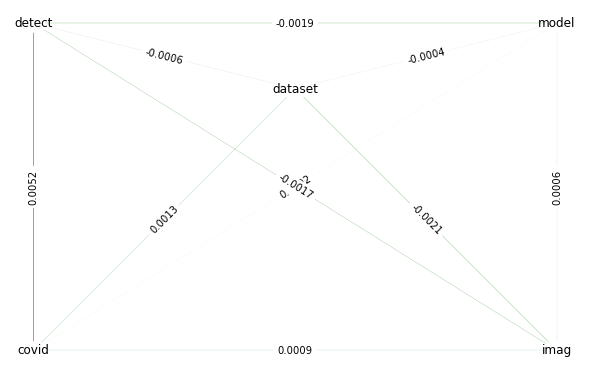

In [53]:
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *100  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='green',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig28.png')

### covid-psychology-large.txt

In [54]:
document_list,titles,word_count_psy=load_data("","covid-psychology-30.txt")

Number of words in text file : 143564
Total Number of Documents: 14623


In [55]:
clean_text=preprocess_data(document_list)

['international', 'sociology']
[]
['author']
['article', 'reuse', 'guidelines']
['sagepub', 'journals', 'permissions']
['0268580920948807']
['journals', 'sagepub']
['psychology', 'politics']
['covid', 'misinfodemics']
['people']
['believe', 'misinfodemics']
['sonia', 'mukhtar']
['university', 'management', 'technology', 'lahore', 'pakistan']
['abstract']
['misinfodemics', 'related', 'covid', 'negatively', 'impacted', 'people', 'lives', 'adverse']
['health', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicate']
['evidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'emerged', 'effects']
['misinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevier']
['about', 'covid', 'related', 'misinfodemics', 'considered', 'reviewed', 'article']
['review', 'examines', 'mechanisms', 'operational',

In [56]:
# LSA Model
number_of_topics=100
words=word_count_psy
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))##dict and encoding matrix values

In [57]:
#These variables are for further experimentation in vertical comparission mantel test
model_psy_paragraph=create_gensim_lsa_model(clean_text,number_of_topics,words)

In [58]:
dict(model_psy.show_topic(0, topn=5))

{'covid': 0.5058519043006957,
 'pandem': 0.38897168596216447,
 'health': 0.32674067947116403,
 'psycholog': 0.31682518807930105,
 'impact': 0.1892801276005076}

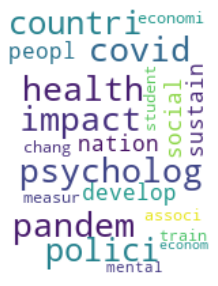

In [59]:
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph26.png')

In [60]:
# LSA Model

a=pd.DataFrame()

for i in range(number_of_topics):
    words_psy =dict(model_psy.show_topic(i, topn=words))
    b=pd.DataFrame(words_psy,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled29.png')

cosine-similarity
                 covid       pandem       health    psycholog       impact
covid                1  0.000666122 -0.000953568   0.00045227   0.00380839
pandem     0.000666122            1  -0.00156702  -0.00168439  0.000683171
health    -0.000953568  -0.00156702            1  0.000344693   -0.0020647
psycholog   0.00045227  -0.00168439  0.000344693            1   0.00301506
impact      0.00380839  0.000683171   -0.0020647   0.00301506            1


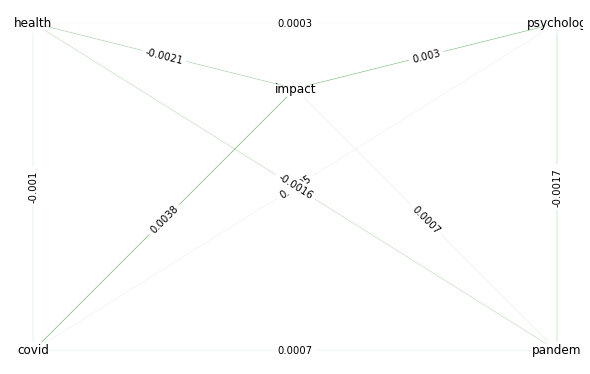

In [61]:
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *100  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='g',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig29.png')

In [62]:
mantel_test(5)

Pairwise-distance
              covid       pandem    health psycholog    impact         imag  \
covid             0      1.36101   1.34207   0.99647  0.992331      1.40755   
pandem      1.36101  1.49012e-08   1.30751   0.92949  0.867754      1.36134   
health      1.34207      1.30751         0  0.899326  0.865892       1.3425   
psycholog   0.99647      0.92949  0.899326         0  0.141088     0.995073   
impact     0.992331     0.867754  0.865892  0.141088         0      1.00679   
imag        1.40755      1.36134    1.3425  0.995073   1.00679  1.49012e-08   
detect      1.39107      1.35038    1.3313  0.975913  0.985488      1.39494   
model       1.40579      1.35763   1.33773  0.991849    1.0025      1.40448   
dataset     1.40694      1.36212   1.34383  0.994567   1.00559      1.40835   

             detect     model   dataset  
covid       1.39107   1.40579   1.40694  
pandem      1.35038   1.35763   1.36212  
health       1.3313   1.33773   1.34383  
psycholog  0.975913  0.

(-0.42116401355894345, 0.9493, -1.2900437573730077)

In [63]:
mantel_test(10)

Pairwise-distance
              covid       pandem    health  psycholog    impact     polici  \
covid             0      1.36101   1.34207    0.99647  0.992331   0.997156   
pandem      1.36101  1.49012e-08   1.30751    0.92949  0.867754   0.928833   
health      1.34207      1.30751         0   0.899326  0.865892   0.896322   
psycholog   0.99647      0.92949  0.899326          0  0.141088  0.0604059   
impact     0.992331     0.867754  0.865892   0.141088         0   0.151617   
polici     0.997156     0.928833  0.896322  0.0604059  0.151617          0   
countri     1.03662     0.962947  0.924044   0.273393  0.284709   0.286962   
develop     1.34108      1.28511   1.30422   0.890659  0.886884   0.890348   
nation      1.02474     0.970237  0.856258   0.231148  0.240748   0.244588   
social      1.17636      1.11902   1.10697   0.626035  0.640214   0.627793   
imag        1.40755      1.36134    1.3425   0.995073   1.00679   0.998422   
detect      1.39107      1.35038    1.3313   0

(-0.3679223283788243, 0.9549, -1.6560744004825445)

In [64]:
def mantel_test_verticle(model_a,model_b,n):
    words_science = dict(model_a.show_topic(0, topn=word_count_science))
    words_psy = dict(model_b.show_topic(0, topn=word_count_psy))

    top_words_science = dict(model_a.show_topic(0, topn=n)) 
    top_words_psy = dict(model_b.show_topic(0,topn=n)) 


    c={} #law words in non law
    for key in top_words_science:
        try:
            c[key] = words_psy[key]
        except KeyError:
            c[key] = 0

    top_words_psy.update(c)

    b={} #non law words in law
    for key in top_words_psy:
        try:
            b[key] = words_science[key]
        except KeyError:
            b[key] = 0

    b.update(top_words_science)
    top_words_science=b

    #pairwise distance for law
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_science =dict(model_a.show_topic(i, topn=word_count_science))
        b=pd.DataFrame(words_from_science,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_science.keys()), 
                      index = list(top_words_science.keys()))

    l = list(top_words_science.keys())

    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df1 = df.to_numpy()
    #pairwise distace for non-law
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_psy =dict(model_b.show_topic(i, topn=word_count_psy))
        b=pd.DataFrame(words_from_psy,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_psy.keys()), 
                      index = list(top_words_psy.keys()))

    l = list(top_words_psy.keys())
    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df2 = df.to_numpy()
    

    dist1 = list(df1[np.triu_indices(len(top_words_science), k = 1)])

    

    dist2 = list(df2[np.triu_indices(len(top_words_psy), k = 1)])

    return mantel.test(dist1, dist2, perms=10000, method='pearson', tail='upper')

In [65]:
mantel_test_verticle(model_science_articles,model_science_p,5)

Pairwise-distance
           support    granada    covid  research     programm     imag  \
support          0   0.223485  1.42271  0.413385      0.22011  1.69171   
granada   0.223485          0  1.48248  0.364757    0.0689622  1.64926   
covid      1.42271    1.48248        0   1.42769      1.48709  2.11875   
research  0.413385   0.364757  1.42769         0     0.344496   1.6372   
programm   0.22011  0.0689622  1.48709  0.344496  6.58545e-10  1.64203   
imag       1.69171    1.64926  2.11875    1.6372      1.64203        0   
model      1.47855    1.43266  2.02369   1.49771      1.43247  2.28313   
dataset    1.27234    1.26162  2.03973   1.28654       1.2706  1.88382   
infect     1.39775    1.33479  1.91033   1.38403      1.32472   2.1512   

            model      dataset   infect  
support   1.47855      1.27234  1.39775  
granada   1.43266      1.26162  1.33479  
covid     2.02369      2.03973  1.91033  
research  1.49771      1.28654  1.38403  
programm  1.43247       1.2706 

(0.145440711993975, 0.3187, 0.5387631552542321)

In [66]:
mantel_test_verticle(model_science_articles,model_science_paragraph,5)

Pairwise-distance
           covid     imag   detect    model      dataset   infect
covid          0  2.11875   1.5681  2.02369      2.03973  1.91033
imag     2.11875        0  1.68503  2.28313      1.88382   2.1512
detect    1.5681  1.68503        0  1.46652      1.51607  1.49186
model    2.02369  2.28313  1.46652        0      1.90777   1.9025
dataset  2.03973  1.88382  1.51607  1.90777  2.10734e-08  1.98535
infect   1.91033   2.1512  1.49186   1.9025      1.98535        0
Pairwise-distance
               covid     imag   detect        model  dataset       infect
covid    1.49012e-08  1.40754  1.39112      1.40551  1.40701      1.39606
imag         1.40754        0   1.3948       1.4039  1.40821       1.3955
detect       1.39112   1.3948        0      1.39236  1.39402      1.37899
model        1.40551   1.4039  1.39236  2.10734e-08  1.40483      1.39248
dataset      1.40701  1.40821  1.39402      1.40483        0      1.39506
infect       1.39606   1.3955  1.37899      1.39248  1.395

(0.6816751411668461, 0.05555555555555555, 1.6183428975756962)

In [67]:
mantel_test_verticle(model_science_p,model_science_paragraph,5)

Pairwise-distance
                covid     imag   detect    model  dataset   support  granada  \
covid     5.26836e-08  1.60718    2.676    2.676    2.676   4.44755  3.34914   
imag          1.60718        0  1.09614  1.09614  1.09614   3.56952  2.37968   
detect          2.676  1.09614        0        0        0   2.99493  1.88382   
model           2.676  1.09614        0        0        0   2.99493  1.88382   
dataset         2.676  1.09614        0        0        0   2.99493  1.88382   
support       4.44755  3.56952  2.99493  2.99493  2.99493         0  1.18984   
granada       3.34914  2.37968  1.88382  1.88382  1.88382   1.18984        0   
research      3.85527  2.76062  2.07496  2.07496  2.07496  0.941912  0.54807   
programm      3.85527  2.76062  2.07496  2.07496  2.07496  0.941912  0.54807   

          research  programm  
covid      3.85527   3.85527  
imag       2.76062   2.76062  
detect     2.07496   2.07496  
model      2.07496   2.07496  
dataset    2.07496   2.074

(0.17537577032539547, 0.249, 0.7889200913998718)

In [68]:
mantel_test_verticle(model_psy_articles,model_psy_p,5)

Pairwise-distance
           misinfodem    covid    articl    mechan       health psycholog  \
misinfodem          0  1.22624  0.687752   0.37179      1.37187   1.29483   
covid         1.22624        0   1.13269   1.16653      1.70937   1.49054   
articl       0.687752  1.13269         0  0.471478      1.32323    1.1446   
mechan        0.37179  1.16653  0.471478         0      1.30919   1.16886   
health        1.37187  1.70937   1.32323   1.30919  2.72057e-08    1.5543   
psycholog     1.29483  1.49054    1.1446   1.16886       1.5543         0   
student       1.43212  1.77758    1.4145      1.35      1.96248   1.70936   
train         1.08638  1.53044   1.09724  0.986214      1.64609    1.4496   
pandem       0.991333  1.25291  0.872575  0.859574      1.32569   1.41942   

            student     train    pandem  
misinfodem  1.43212   1.08638  0.991333  
covid       1.77758   1.53044   1.25291  
articl       1.4145   1.09724  0.872575  
mechan         1.35  0.986214  0.859574  
h

(-0.4236465849544569, 0.9075, -1.4416013880099683)

In [69]:
mantel_test_verticle(model_psy_articles,model_psy_paragraph,5)

Pairwise-distance
             covid    pandem       health psycholog    impact  student  \
covid            0   1.25291      1.70937   1.49054   1.26858  1.77758   
pandem     1.25291         0      1.32569   1.41942  0.958735  1.58892   
health     1.70937   1.32569  2.72057e-08    1.5543   1.45186  1.96248   
psycholog  1.49054   1.41942       1.5543         0   1.25822  1.70936   
impact     1.26858  0.958735      1.45186   1.25822         0  1.55855   
student    1.77758   1.58892      1.96248   1.70936   1.55855        0   
train      1.53044   1.12457      1.64609    1.4496   1.17141  1.53934   

             train  
covid      1.53044  
pandem     1.12457  
health     1.64609  
psycholog   1.4496  
impact     1.17141  
student    1.53934  
train            0  
Pairwise-distance
                 covid   pandem   health psycholog       impact    student  \
covid      2.10734e-08  1.40729  1.39971   1.40321       1.3932    1.40439   
pandem         1.40729        0   1.3997     1.

(0.2068717780661167, 0.3119047619047619, 0.533668883017913)

In [70]:
mantel_test_verticle(model_psy_p,model_psy_paragraph,5)

Pairwise-distance
              covid   pandem       health    psycholog    impact misinfodem  \
covid             0  2.70574      1.67187      1.70328     2.236    1.35287   
pandem      2.70574        0      1.22885      2.52328   1.89336    4.05861   
health      1.67187  1.22885            0      1.35447    1.0317    2.98805   
psycholog   1.70328  2.52328      1.35447  2.63418e-08  0.901913    2.58051   
impact        2.236  1.89336       1.0317     0.901913         0    3.34632   
misinfodem  1.35287  4.05861      2.98805      2.58051   3.34632          0   
articl      1.13552   2.4577      1.22885     0.567759   1.25066    2.09875   
mechan      1.67187  1.22885  1.31709e-08      1.35447    1.0317    2.98805   

              articl       mechan  
covid        1.13552      1.67187  
pandem        2.4577      1.22885  
health       1.22885  1.31709e-08  
psycholog   0.567759      1.35447  
impact       1.25066       1.0317  
misinfodem   2.09875      2.98805  
articl            

(-0.2565147941043175, 0.7571, -0.8699727201185447)

In [71]:
mantel_test_verticle(model_science_articles,model_science_p,10)

Pairwise-distance
           support    granada    covid  research     programm      tabik  \
support          0   0.223485  1.42271  0.413385      0.22011     0.2392   
granada   0.223485          0  1.48248  0.364757    0.0689622  0.0518868   
covid      1.42271    1.48248        0   1.42769      1.48709    1.48088   
research  0.413385   0.364757  1.42769         0     0.344496   0.387967   
programm   0.22011  0.0689622  1.48709  0.344496  6.58545e-10    0.12065   
tabik       0.2392  0.0518868  1.48088  0.387967      0.12065          0   
garcía    0.219028  0.0398597  1.48393  0.352682     0.033649  0.0904457   
project   0.304077    0.23393  1.50273  0.361183     0.194704   0.270695   
decsai    0.218931  0.0517217  1.48564  0.348394    0.0172406   0.103434   
chart     0.207104  0.0616361  1.48263  0.353467    0.0313129   0.110173   
imag       1.69171    1.64926  2.11875    1.6372      1.64203    1.65663   
model      1.47855    1.43266  2.02369   1.49771      1.43247    1.435

(0.13930710190209936, 0.2373, 0.767812166029734)

In [72]:
mantel_test_verticle(model_science_articles,model_science_paragraph,10)

Pairwise-distance
             covid     imag    detect    model      dataset    learn  \
covid            0  2.11875    1.5681  2.02369      2.03973  1.82669   
imag       2.11875        0   1.68503  2.28313      1.88382  2.01278   
detect      1.5681  1.68503         0  1.46652      1.51607  1.34993   
model      2.02369  2.28313   1.46652        0      1.90777   1.7857   
dataset    2.03973  1.88382   1.51607  1.90777  2.10734e-08  1.77198   
learn      1.82669  2.01278   1.34993   1.7857      1.77198        0   
pneumonia  1.64921   1.6122    1.1819   1.5368      1.63545  1.38688   
volum      1.43082  1.64298  0.713563  1.47868      1.26232  1.18257   
infect     1.91033   2.1512   1.49186   1.9025      1.98535  1.63526   
patient    1.38896  1.77817  0.890023  1.70001      1.37027  1.26703   
class      1.64859  1.89507   1.23331  1.71295       1.5935  1.46287   
perform    1.55939  1.75666   0.95631  1.21745      1.46999  1.27695   
train       1.5014   1.4744  0.930497   1.4742

(0.4846487756328932, 0.0124, 1.7413670427112125)

In [73]:
mantel_test_verticle(model_science_p,model_science_paragraph,10)

Pairwise-distance
                 covid     imag    detect     model   dataset     learn  \
covid      5.26836e-08  1.60718     2.676     2.676     2.676     2.676   
imag           1.60718        0   1.09614   1.09614   1.09614   1.09614   
detect           2.676  1.09614         0         0         0         0   
model            2.676  1.09614         0         0         0         0   
dataset          2.676  1.09614         0         0         0         0   
learn            2.676  1.09614         0         0         0         0   
pneumonia            0        0         0         0         0         0   
volum                0        0         0         0         0         0   
infect               0        0         0         0         0         0   
patient        2.13813  0.54807   0.54807   0.54807   0.54807   0.54807   
support        4.44755  3.56952   2.99493   2.99493   2.99493   2.99493   
granada        3.34914  2.37968   1.88382   1.88382   1.88382   1.88382   
researc

(0.0014144051551928673, 0.5059, -0.00100830341448026)

In [74]:
mantel_test_verticle(model_psy_articles,model_psy_p,10)

Pairwise-distance
           misinfodem    covid    articl    mechan       health    commun  \
misinfodem          0  1.22624  0.687752   0.37179      1.37187  0.941082   
covid         1.22624        0   1.13269   1.16653      1.70937   1.54444   
articl       0.687752  1.13269         0  0.471478      1.32323  0.940223   
mechan        0.37179  1.16653  0.471478         0      1.30919  0.880696   
health        1.37187  1.70937   1.32323   1.30919  2.72057e-08   1.61778   
commun       0.941082  1.54444  0.940223  0.880696      1.61778         0   
strategi     0.337806  1.18533   0.50035   0.20235      1.29213  0.865798   
psycholog     1.29483  1.49054    1.1446   1.16886       1.5543   1.42844   
misinform    0.191645  1.18524  0.552794  0.190129      1.32442  0.894876   
inform       0.424364  1.21554   0.66394  0.363357      1.37653  0.970611   
student       1.43212  1.77758    1.4145      1.35      1.96248   1.58406   
train         1.08638  1.53044   1.09724  0.986214      1.

(-0.25187105487199196, 0.9003, -1.3281938535167732)

In [75]:
mantel_test_verticle(model_psy_articles,model_psy_paragraph,10)

Pairwise-distance
              covid    pandem       health psycholog    impact       polici  \
covid             0   1.25291      1.70937   1.49054   1.26858      1.18278   
pandem      1.25291         0      1.32569   1.41942  0.958735     0.874676   
health      1.70937   1.32569  2.72057e-08    1.5543   1.45186      1.35839   
psycholog   1.49054   1.41942       1.5543         0   1.25822      1.11921   
impact      1.26858  0.958735      1.45186   1.25822         0     0.676389   
polici      1.18278  0.874676      1.35839   1.11921  0.676389  6.80142e-09   
countri     1.02891   1.10944      1.61179   1.34752   1.10418     0.880275   
develop     1.22073   0.75019       1.2968   1.15831  0.664806     0.387264   
nation      1.34164   1.05101      1.38854   1.26337  0.786143     0.599575   
social      1.53777   1.24826      1.60746   1.50426      1.27      1.12965   
student     1.77758   1.58892      1.96248   1.70936   1.55855      1.44428   
train       1.53044   1.12457     

(0.593484625495186, 0.0008, 2.3498379627192807)

In [76]:
mantel_test_verticle(model_psy_p,model_psy_paragraph,10)

Pairwise-distance
              covid    pandem       health    psycholog    impact polici  \
covid             0   2.70574      1.67187      1.70328     2.236      0   
pandem      2.70574         0      1.22885      2.52328   1.89336      0   
health      1.67187   1.22885            0      1.35447    1.0317      0   
psycholog   1.70328   2.52328      1.35447  2.63418e-08  0.901913      0   
impact        2.236   1.89336       1.0317     0.901913         0      0   
polici            0         0            0            0         0      0   
countri           0         0            0            0         0      0   
develop       2.236   1.89336       1.0317     0.901913         0      0   
nation            0         0            0            0         0      0   
social      2.70574         0      1.22885      2.52328   1.89336      0   
misinfodem  1.35287   4.05861      2.98805      2.58051   3.34632      0   
articl      1.13552    2.4577      1.22885     0.567759   1.25066     

(-0.227177667706413, 0.8638, -1.1338101961462617)